<a href="https://colab.research.google.com/github/pikey-msc/AprendizMaquina/blob/main/2023-1/Ensambles/Bagging_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Carga de información GITHUB

In [1]:
try:
    !rm -rf CursoDF
except:
    print("No existe la ruta aún")

!git clone "https://github.com/pikey-msc/CursoDF"

Cloning into 'CursoDF'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 246 (delta 3), reused 0 (delta 0), pack-reused 232
Receiving objects: 100% (246/246), 19.70 MiB | 4.65 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [4]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load in the r magic
# %reload_ext rpy2.ipython

!pip uninstall rpy2 -y

!pip install rpy2==3.5.1


Found existing installation: rpy2 3.5.5
Uninstalling rpy2-3.5.5:
  Successfully uninstalled rpy2-3.5.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 201 kB 13.0 MB/s 
  Created wheel for rpy2: filename=rpy2-3.5.1-cp37-cp37m-linux_x86_64.whl size=310605 sha256=a2bc16416d880f5dff04787831ad36071b20963a120f2f861e064e1d43cbd3e8
  Stored in directory: /root/.cache/pip/wheels/65/df/9e/39aa22a3f47ec58751b5bf6907036fbc131d85b6d7cbd3b3fe
Successfully built rpy2


#Carga de librerías

In [2]:
#Cargar módulo de R en Python
# A bit of imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Load in the r magic
%reload_ext rpy2.ipython
%config IPCompleter.greedy=True
%config InlineBackend.figure_format = 'retina'

In [42]:
%%R
install.packages("caret")
library(caret)

(as ‘lib’ is unspecified)



























































	‘/tmp/RtmpL5ElQ4/downloaded_packages’


Attaching package: ‘lattice’



    melanoma


Attaching package: ‘caret’



    confusionMatrix, precision, recall, sensitivity, specificity




In [3]:
%%R
#install.packages("dplyr")
library(dplyr) # "Libreria utilizada para manejar datos"
library(rpart)
# install.packages("rpart.plot")
# library(rpart.plot)

install.packages("e1071")
library(e1071)
install.packages("ModelMetrics")
library(ModelMetrics)
install.packages("party")
library(party)
install.packages("boot")
library(boot)
install.packages("ipred")
library(ipred)
install.packages("randomForest")
library(randomForest)
library(ggplot2)
install.packages("ISLR")
library(ISLR)



Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union


(as ‘lib’ is unspecified)














	‘/tmp/RtmpL5ElQ4/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmpL5ElQ4/downloaded_packages’

Attaching package: ‘ModelMetrics’



    kappa


(as ‘lib’ is unspecified)



























































	‘/tmp/RtmpL5ElQ4/downloaded_packages’







Attaching package: ‘zoo’



    as.Date, as.Date.numeric



(as ‘lib’ is unspecified)







	‘/tmp/RtmpL5ElQ4/downloaded_packages’

(as ‘lib’ is unspecified)



























































	‘/tmp/RtmpL5ElQ4/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpL5ElQ4/downloaded_packages’



Attaching package: ‘randomForest’



    combine


Attaching package: ‘ggplot2’



    margin


(as ‘lib’ is unspecified)







	‘/tmp/RtmpL5ElQ4/downloaded_packages’



## Árbol Bagging
**Definición de los arboles BAGGING**\
Los modelos basados en arboles BAGGING son una extensión de los modelos basados en arboles de decision.

Este tipo de modelos utilizan un modelo Bootstrap que crea distintas base de entramiento train que se utilizan para calcular diferentes tipos de arboles de decision, mediante este metodo es posible obtener la predicción de los distintos conjuntos de datos bootstrap y ensamblar todos esto resultados en un solo conjunto mediante el promedio.

De ahí el termino de arbol BAGGING (Bootstrap AGGregationING) por el agrupamiento del modelo.

El objetivo de estos modelos es tener un mejor performance: 
1. Reducir la alta variabilidad de la varianza de los modelos de arboles de decision 

2. Evitar que cambios pequeños en los datos deriven en cambios radicales en el arbol de decision.

**Modelo Bootstrap**\
Sea $Z=(x_1,y_1),(x_2,y_3),…,(x_n,y_n)$, el conjunto de datos de entranamiento en el cual se desea ajutar un modelo


<div class="figure">
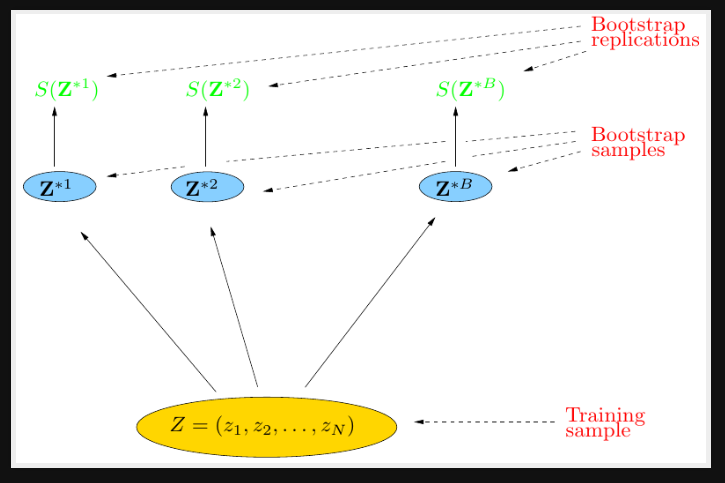

</div>


La idea de bootstrap consiste en muestrear aleatoriamente con reemplazo subconjuntos de entrenamiento del mismo tamañano que el conjunto Z para ajustar distintos modelos con estos datos.

Consideremos el problema de regresión, suponemos que se desea ajustar el modelo a los datos, $Z=(x_1,y_1),(x_2,y_3),\ldots,(x_n,y_n)$ y que $f(x)$ es el modelo que predice $y$.


Mediante bagging se obtendrá un estimador que será el resultado de promediar las estimaciones obtenidas mediante distintas muestras de los datos obtenidas mediante bootstrap.


Para cada muestra $Z^b$ ,$b=1,2,…,B$, se ajustará un modelo y se obtendrá la estimación de $f^b(x)$. El estimador final se define de la siguiente forma:
$$f_{b}ag(x)=\frac{1}{B} \sum f(x)$$

<div class="figure">
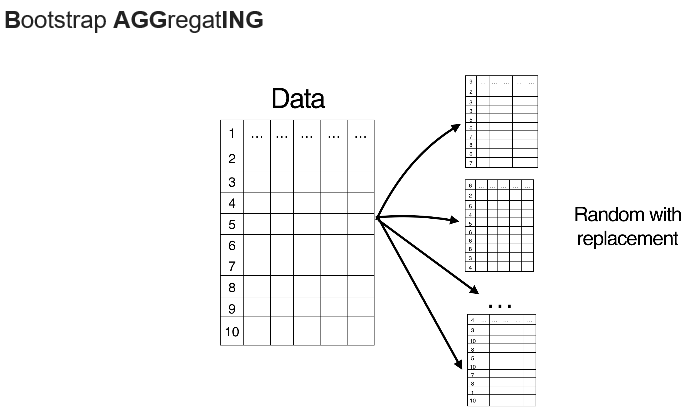

</div>


<div class="figure">
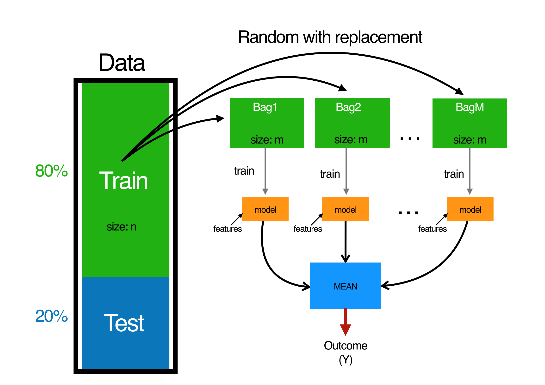

</div>


#### Ejemplo arbol bagging
Entrenamos el modelo de arbol bagging de la tablas de crédito
Para calcular el modelo es necesario utilizar la función ``ipredpackage``. El numero de arboles puede especificarse utilizando el parametro nbagg o el defautl de 25.


Para calcular el accurancy se utiliza muestras OBB (out-of-bag). Las cuales son observaciones de entrenamiento que no fueron seleccionadas dentro de la muestra bootstrap. al no ser utilizadas en entrenamiento, se pueden reutilizar evaluando el accuracy del modelo

In [22]:
%%R
credit <- read.table("CursoDF/M3/Datos/credit.txt")

credit=mutate(credit,V21=as.factor(V21))

cred_nam=c("Status of existing checking account","Duration in month","Credit history","Purpose","Credit amount","Present employment since","Installment rate in percentage of disposable income","Personal status and sex","Other debtors / guarantors","Present residence since","Property","A124 : unknown / no property","Age in years","Other installment plans","Housing","Number of existing credits at this bank","Job","Number of people being liable to provide maintenance for","Telephone","foreign worker", "V21")

names(credit)=cred_nam

names(credit)<-make.names(names(credit))

print(summary(credit))
# Define el numero total de renglones de los datos

n <- nrow(credit)

## Define el número de renglones para el conjunto de entrenamiento (80% de la base de datos) 

n_train <- round(n * .60) 

# sample(n_train)

## Crea un vector de indices que sea el 80% de la muestra aleatoria

# set.seed(2^25)

train_indices <- sample( n_train)

# Obten el conjunto de indices para los datos de entrenamiento 

credit_train <- credit[train_indices,]#  
print("Tamaño datos entrenamiento:")
print(nrow(credit_train))
# Excluye los indices de entrenamiento para crear el conjunto de prueba

 credit_test <- credit[-train_indices, ]   
print("Tamaño datos prueba:")
print(nrow(credit_test))

 Status.of.existing.checking.account Duration.in.month Credit.history    
 Length:1000                         Min.   : 4.0      Length:1000       
 Class :character                    1st Qu.:12.0      Class :character  
 Mode  :character                    Median :18.0      Mode  :character  
                                     Mean   :20.9                        
                                     3rd Qu.:24.0                        
                                     Max.   :72.0                        
   Purpose          Credit.amount   Present.employment.since
 Length:1000        Min.   :  250   Length:1000             
 Class :character   1st Qu.: 1366   Class :character        
 Mode  :character   Median : 2320   Mode  :character        
                    Mean   : 3271                           
                    3rd Qu.: 3972                           
                    Max.   :18424                           
 Installment.rate.in.percentage.of.disposable.income Pe

In [23]:
%%R
# Para volverlo a reproducir usamos semilla 123
set.seed(123)

# Modelo de Arbol Bagging
credit_model <- bagging(formula = V21 ~ ., 
                        data = credit_train,
                        coob = TRUE)

# imprimimos el modelo
print(credit_model)


Bagging classification trees with 25 bootstrap replications 

Call: bagging.data.frame(formula = V21 ~ ., data = credit_train, coob = TRUE)

Out-of-bag estimate of misclassification error:  0.2683 



Prediccion y matrix de confusión del modelo de arbol bagging

In [34]:
%%R
class_prediction <- predict(object = credit_model,    
                            newdata = credit_test,  
                            type = "class")  # return classification labels

# Print the predicted classes
print(sum(as.numeric(class_prediction)-as.numeric(credit_test$V21))/290)
# print(credit_test$V21)
confusionMatrix(as.numeric(class_prediction),as.numeric(credit_test$V21))



[1] -0.04482759
     [,1] [,2]
[1,]    0    0
[2,]    0  290


Prediccion y calculo del AUC del modelo de arbol bagging


In [35]:
%%R
pred <- predict(object = credit_model,
                newdata = credit_test,
                type = "prob")

# `pred es una matrix
class(pred)


credit_model$mtrees
credit_model$call
# Calculo del AUC
auc(actual = ifelse(credit_test$V21 == "1", 1, 0), 
    predicted = pred[,"1"]) 



[1] 0.7457955


#Random Forest (Bosques aleatorios)
**Introduccion**\
Random Forest es un algoritmo de aprendizaje supervisado que puede ser utilizado para problemas de regresión o clasificación


Estos algoritmos fueron desarrollados por Breiman (2001), los conceptos en los que se base son los siguientes:
* Árboles (de clasificación o regresión)
* Bagging: Esta técnica se basa en el remuestreo conocido como boostrap, que tiene una gran eficiencia mejorando el desemepeño de estimadores. Se puede demostrar que la media obtenida tras un proceso de bootstrap se aproxima a la media de la distribución posterior


La precisión e importancia de las variables forman parte de los resultados del modelo


La diferencia entre em modelo Random Forest y Bagging se basa en que el modelo Random Forest utiliza un subconjunto de características que se selecciona al azar en cada división de un árbol de decisión. En el Bagging, se utilizan todas las características.


Fueron nombrados de esta forma por Tim Kam Ho de Bell Labs en 1995

**Ventajas**
* Este método que genera un modelo con alto grado de precisión y el aprendizaje es rápido en comparación a otros algoritmos
* Es posible paralelizar el algoritmo en su totalidad.
Puede manejar bases completas sin necesidad de quitar variables inútiles
* Puede encontrar interacciones complejas entre variables.
* Funciona con variables categóricas y numéricas.
* Trabaja de forma efectiva con datos faltantes, dependiendo el tipo de árbol que se use es el tratamiento que le dará.
* No es necesario escalar variables o hacer tranformaciones de variables de categóricas para utilizarlo.

**Desventajas**
* Pueden llegar a sobreajustar la muestra.
* Si la base de datos tiene datos categóricos con distintos niveles, el algoritmo tendrá un sesgo hacia las variables con más niveles por lo que el modelo final puede no ser tan bueno y además la importancia de las variables no será confiable.


**Algoritmo**\
Paso 1. Selecciona individuos al azar con modelo bootstrap (usando muestreo con reemplazo) para crear diferentes conjuntos de datos $X_m$.\
Paso 2. Crea un árbol de decisión con cada conjunto de datos $X_m$ obteniendo diferentes arboles “Tm”, ya que cada conjunto contiene diferentes individuos y diferentes variables en cada nodo.\
Paso 3. Al crear los arboles se eligen variables al azar en cada nodo del arbol, dejando crecer el arbol en profundidad (es decir, sin podar).\
Paso 4. Predice los nuevos datos usando el “voto mayoritario”, donde se obtendra la clase final como “positiva” si la mayoría de los arboles predicen la observación como positiva.

**Intuición grafica del modelo Random Forest**

<div class="figure">
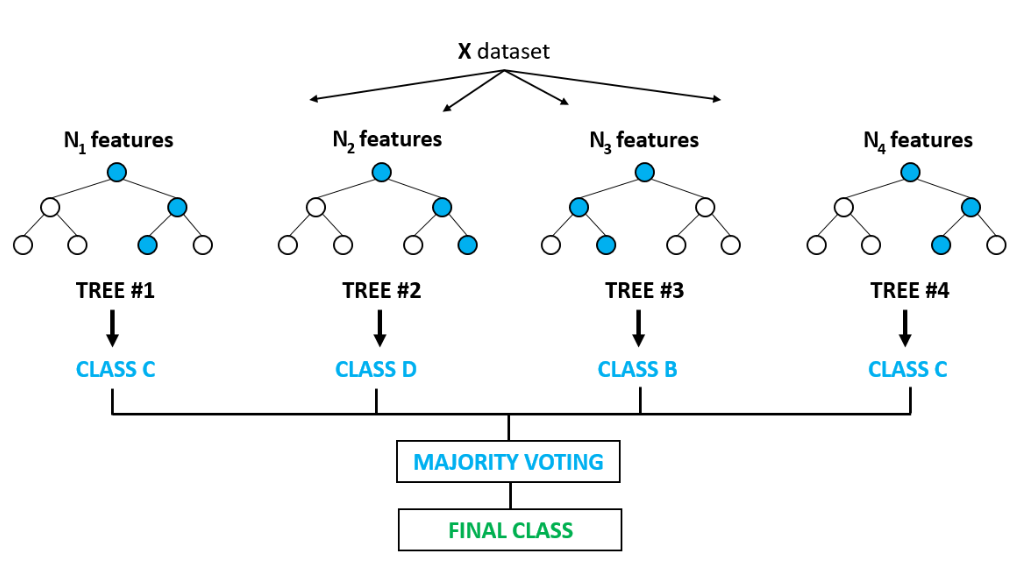

</div>

Para este caso particular, la clase $C$ sera la clase de predicción.

**OOB error (out of bag error)**\
Cuando el algoritmo random forest selecciona una muestra con reemplazo para crear un árbol en una iteración Xm, algunas observaciones se quedan fuera (out of bag) y no son usadas para crear el árbol.
Para esas observaciones que quedaron fuera del árbol, se hace una predicción y se calcula el error de la predicción.
Esto se hace en cada iteración para calcular el error estimado, llamado OOB error.

**Intuicion grafica del OOB error (out of bag error)**

<div class="figure">
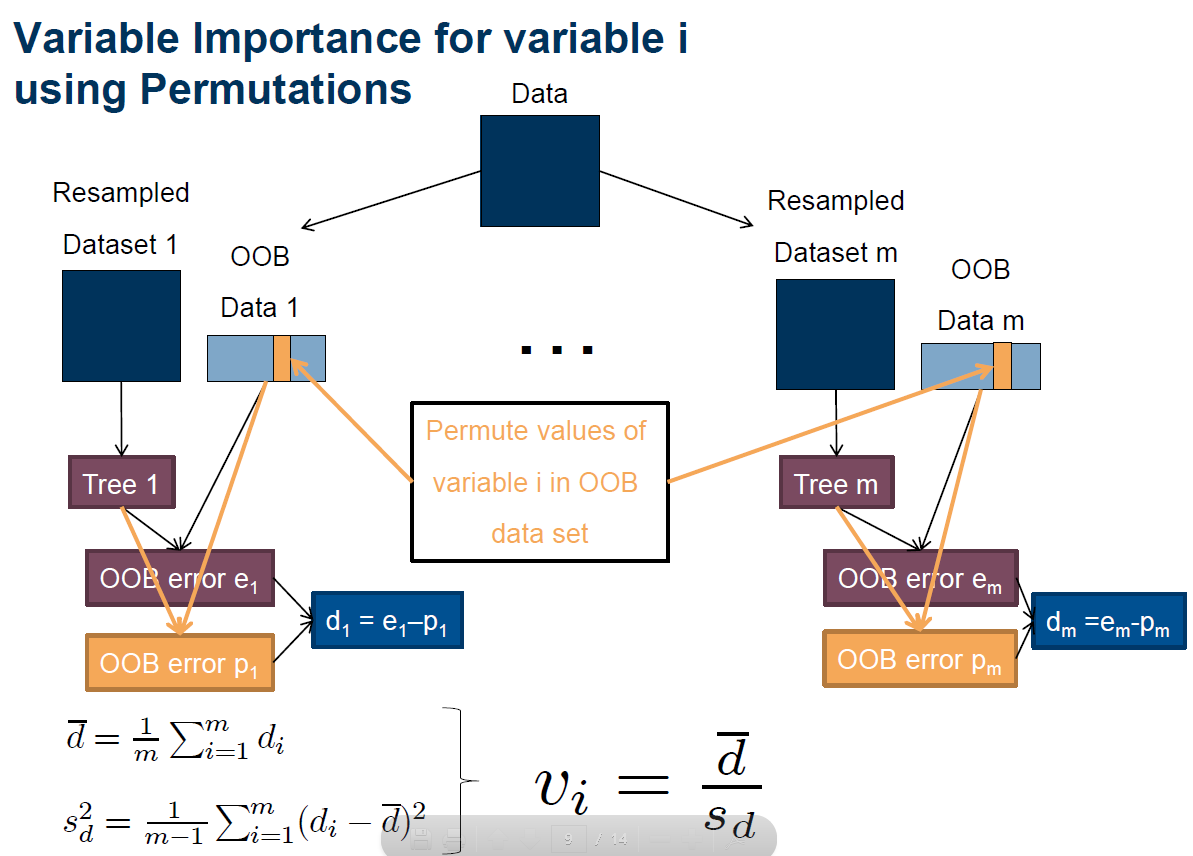

</div>


**Graficar del error del modelo**\
Para saber el promedio del error a medida que se agregan más arboles, puede usarse ``plot(modelo_rf)`` que identifica el OOB promedio acumulado en cada iteración, como también los errores de la clase que se quiere predecir.
En este gráfico se muestra un modelo que intenta predecir la variable ``churn={yes,no}``. La linea negra representa el OOB, la linea roja es el error al intentar predecir ``churn={yes}``, y la linea verde es el error en la prediccion ``churn={no}``. La linea negra siempre será el OOB, y las siguientes lineas se pueden identificar con la matriz de confusión usando ``print(modelo_rf)`` .

<div class="figure">
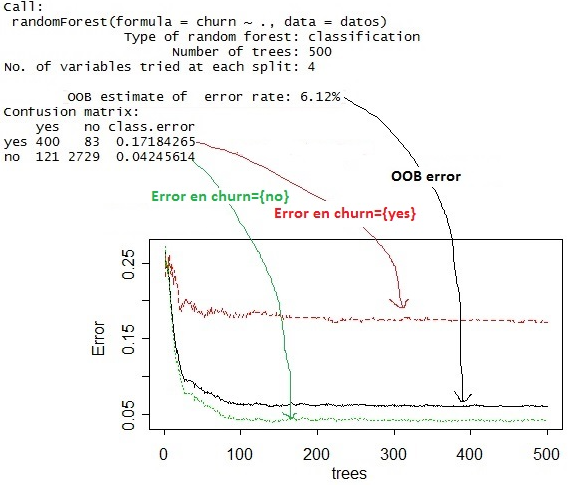

</div>


Notas: En este gráfico existirán tantas lineas como cantidad de clases que se quieran predecir. En el ejemplo anterior solo hay dos: churn=si y churn=no. Cuando la predicción sea de un valor numérico (regresión), entonces solo se graficará la linea del OOB error. . Cuando todas las lineas se superponen, indica que todas las medidas tienen mismo error y no tiene sentido idenficarlas.

#### Ejemplo datos IRIS

ntree      OOB      1      2      3|    Test      1      2      3
   10:   5.04%  0.00%  2.56% 12.50%|   3.33%  0.00%  0.00% 10.00%
   20:   5.00%  0.00%  5.13% 10.00%|   6.67%  0.00%  9.09% 10.00%
   30:   5.83%  0.00%  5.13% 12.50%|   6.67%  0.00%  9.09% 10.00%
   40:   5.00%  0.00%  5.13% 10.00%|   6.67%  0.00%  9.09% 10.00%
   50:   5.83%  0.00%  5.13% 12.50%|   6.67%  0.00%  9.09% 10.00%
   60:   5.83%  0.00%  5.13% 12.50%|   6.67%  0.00%  9.09% 10.00%
   70:   5.00%  0.00%  5.13% 10.00%|   6.67%  0.00%  9.09% 10.00%
   80:   5.00%  0.00%  5.13% 10.00%|   6.67%  0.00%  9.09% 10.00%
   90:   5.83%  0.00%  5.13% 12.50%|   6.67%  0.00%  9.09% 10.00%
  100:   5.83%  0.00%  5.13% 12.50%|   6.67%  0.00%  9.09% 10.00%

Call:
 randomForest(formula = Species ~ ., data = train, xtest = test[,      -5], ytest = test$Species, ntree = 100, do.trace = 10) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 2

    

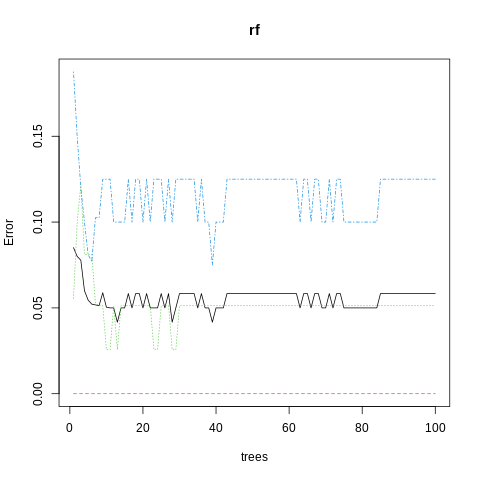

In [38]:
%%R
# Muestra del 80% del total

smp_size <- floor(0.80 * nrow(iris))

# fijar la semilla para que la muestra pueda ser reproducible
# 42 es la respuesta al sentido de la vida, el universo y todo lo demás

set.seed(42)

train_ind <- sample(seq_len(nrow(iris)), size = smp_size)

# print(train)
train <- iris[train_ind, ]

test <- iris[-train_ind, ]


rf <- randomForest(Species ~., data = train,
                   xtest = test[,-5], ytest = test$Species,
                   ntree = 100,
                   do.trace = 10)
print(rf)
plot(rf)

Matriz de confusión en lso datos de prueba e importancia de variables

           setosa versicolor virginica class.error
setosa          9          0         0  0.00000000
versicolor      0         10         1  0.09090909
virginica       0          1         9  0.10000000


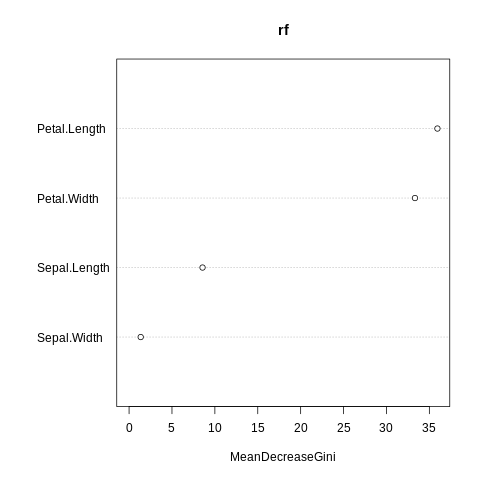

In [39]:
%%R
print(rf$test$confusion)

varImpPlot(rf)

In [45]:
%%R
head(credit_train)

    Status.of.existing.checking.account Duration.in.month Credit.history
271                                 A14                18            A32
531                                 A12                36            A32
592                                 A12                24            A33
456                                 A14                24            A32
557                                 A12                18            A30
495                                 A11                12            A34
    Purpose Present.employment.since
271     A40                      A65
531     A46                      A61
592     A40                      A65
456     A41                      A61
557     A40                      A62
495     A40                      A61
    Installment.rate.in.percentage.of.disposable.income Personal.status.and.sex
271                                                 A74                       4
531                                                 A74               

### Ejemplo con datos de crédito



Call:
 randomForest(formula = as.factor(V21) ~ ., data = credit_train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 25.33%
Confusion matrix:
    1  2 class.error
1 378 45   0.1063830
2 107 70   0.6045198
           OOB         1         2
[1,] 0.3066667 0.1730769 0.6086957
[2,] 0.3061798 0.1912351 0.5809524
[3,] 0.2968037 0.1974110 0.5348837
[4,] 0.2880325 0.1613833 0.5890411
[5,] 0.3106061 0.1805930 0.6178344
[6,] 0.3009009 0.1568123 0.6385542
      OOB 
0.2533333 
Confusion Matrix and Statistics

          Reference
Prediction   1   2
         1 244  68
         2  33  55
                                          
               Accuracy : 0.7475          
                 95% CI : (0.7019, 0.7894)
    No Information Rate : 0.6925          
    P-Value [Acc > NIR] : 0.0090331       
                                          
                  Kappa : 0.356

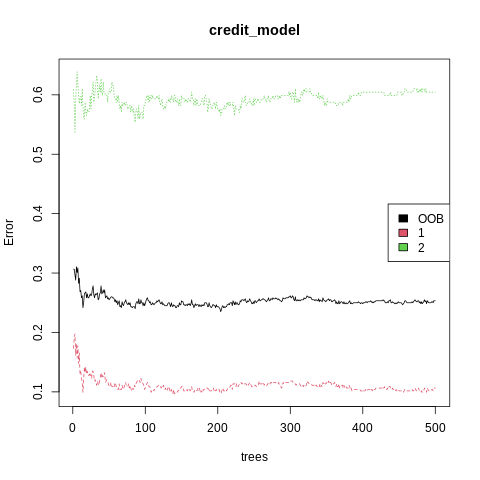

In [47]:
%%R
set.seed(2**8)  # para repoducirlos poner 1

# Quitar V5
# credit_train=subset(credit_train,select=-Credit.amount)
# credit_test=subset(credit_test,select=-Credit.amount)

credit_model <- randomForest(formula = as.factor(V21) ~ .  ,data = credit_train)  


# Ver el modelo

print(credit_model)

err <- credit_model$err.rate
print(head(err))

oob_err <- err[nrow(err), "OOB"]
print(oob_err)

#grafica errores modelo
plot(credit_model)

# Agrega una leyenda
legend(x = "righ", 
       legend = colnames(err),
       fill = 1:ncol(err))

class_prediction <- predict(object = credit_model,   # modelo objeto 
                            newdata = credit_test,   # datos test
                            type = "class")

cm <- caret::confusionMatrix(class_prediction,as.factor(credit_test$V21))  # clases actuales
print(cm)


Modelo con más ramas

ntree      OOB      1      2
   10:  29.90% 15.62% 63.64%
   20:  28.50% 13.95% 63.28%
   30:  28.50% 12.29% 67.23%
   40:  26.00%  9.69% 64.97%
   50:  25.67%  9.46% 64.41%
   60:  26.67% 10.17% 66.10%
   70:  26.17% 10.64% 63.28%
   80:  27.83% 12.29% 64.97%
   90:  27.67% 12.77% 63.28%
  100:  25.50% 11.35% 59.32%


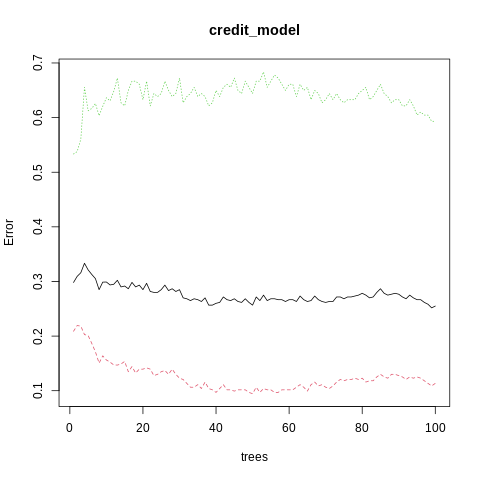

In [48]:
%%R
credit_model <- randomForest(formula = as.factor(V21) ~ .,data = credit_train, ntree=100, do.trace=10)  
plot(credit_model)

pred <- predict(object = credit_model, 
                newdata = credit_test,
                type = "prob")


Evaluar métrica AUC

In [49]:
%%R
# `pred` es matrix
print(class(pred))

auc(actual = ifelse(credit_test$V21 == "1", 1, 0), 
    predicted = pred[,"1"])  


[1] "matrix" "array"  "votes" 
[1] 0.7728714


**Hiperparametros modelo Random Forest**
* ``ntrees`` = numero de arboles. Por default n = 500
* ``mtry`` =numero de variables aleatorias muestreadas en cada segmento
* ``sampsize``=numero de muestras en la base train. Por default $n = 63$
* ``nodesize``=número de muestras minimo de cada nodo
maxnodes=número máximo de nodos terminales

mtry = 4  OOB error = 24% 
Searching left ...
mtry = 2 	OOB error = 23.17% 
0.03472222 0.05 
Searching right ...
mtry = 8 	OOB error = 25.5% 
-0.0625 0.05 
      mtry  OOBError
2.OOB    2 0.2316667
4.OOB    4 0.2400000
8.OOB    8 0.2550000


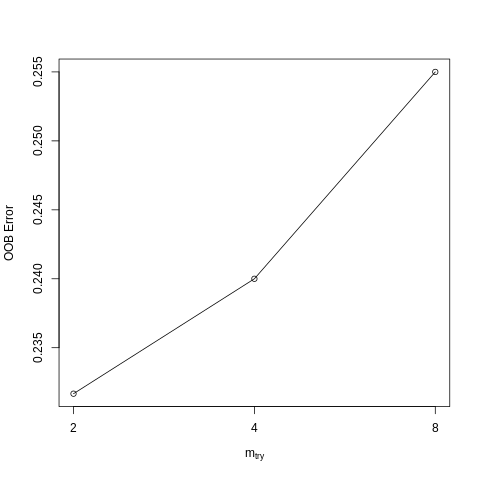

In [50]:
%%R
set.seed(2**20)              
res <- tuneRF(x = subset(credit_train, select = -V21),
              y = as.factor(credit_train$V21),
              ntreeTry = 500)
print(res)


Tunear un modelo random forest variando mtry, nodesize y sampsize

In [51]:
%%R
mtry <- seq(4, ncol(credit_train) * 0.8, 2)
nodesize <- seq(3, 8, 2)
sampsize <- nrow(credit_train) * c(0.7, 0.8)

# Crear el data frame con todas las combinaciones

hyper_grid <- expand.grid(mtry = mtry, nodesize = nodesize, sampsize = sampsize)

print(head(hyper_grid))

# Crear un vector vacio para guardar el OOB error

oob_err <- c()

# Loop sobre los renglones para obtener diferentes modelos

for (i in 1:nrow(hyper_grid)) {
  
  # Entrena un modelo randmo forest
  
  model <- randomForest(formula = as.factor(V21) ~ .,
                        data = credit_train,
                        mtry = hyper_grid$mtry[i],
                        nodesize = hyper_grid$nodesize[i],
                        sampsize = hyper_grid$sampsize[i], ntree=70)
  
  # Guarda el error OOB       
  
  oob_err[i] <- model$err.rate[nrow(model$err.rate), "OOB"]
}

# Identifica los hiperparametros optimos en base al OOB
opt_i <- which.min(oob_err)
print(hyper_grid[opt_i,])

print(oob_err)

credit_model$confusion



  mtry nodesize sampsize
1    4        3      420
2    6        3      420
3    8        3      420
4   10        3      420
5   12        3      420
6   14        3      420
   mtry nodesize sampsize
22    4        3      480
 [1] 0.2600000 0.2583333 0.2566667 0.2566667 0.2733333 0.2566667 0.2433333
 [8] 0.2450000 0.2433333 0.2550000 0.2600000 0.2633333 0.2500000 0.2550000
[15] 0.2483333 0.2433333 0.2516667 0.2500000 0.2600000 0.2600000 0.2500000
[22] 0.2383333 0.2466667 0.2516667 0.2500000 0.2616667 0.2733333 0.2766667
[29] 0.2400000 0.2533333 0.2566667 0.2466667 0.2616667 0.2650000 0.2600000
[36] 0.2483333 0.2533333 0.2533333 0.2416667 0.2483333 0.2583333 0.2733333
    1  2 class.error
1 375 48   0.1134752
2 105 72   0.5932203
